# Mini Project 1: Model Interpretation with LIME
---
***Important***:
- Before starting the lab please copy this notebook into your own google drive by clicking on "File" and "Save a copy in drive"
- If you want to work locally, make sure that you also download all other files together to the same directory
---

In this lab, we will practice using the Local Interpretable Model-agnostic Explanations, or LIME, technique on neural networks.

HINT:
- Search "Check-" in browser search (cmd+f mac, ctrl+f windows)
- You can also open the "table of contents" from the side menu on the left side of your screen

Here are some boilerplate codes to make the notebook compatible with both Colab and local Jupyter environments.

In [2]:
import os
import sys

isColab = "google.colab" in sys.modules
# this also works:
# isColab = "COLAB_GPU" in os.environ

if isColab:
    from google.colab import drive
    drive.mount("/content/drive", force_remount=True)

    # colab_path = ("/content/drive/Shared drives"
    #     + "/CS1470 TAs Fall 2022/Labs/lab04_lime")

    # TODO: fill in path stencil below, and download appropriate files to your
    # local colab dir
    student_colab_path = ("/content/drive/MyDrive"
        + "/Semester1/DeepLearning")
    sys.path.append(student_colab_path)

Mounted at /content/drive


In [3]:
import numpy as np
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import json, itertools

from sklearn.linear_model import Lasso # Lasso Regression for the glassbox model in LIME
from skimage.color import rgb2gray # Convert the unimportant areas into grayscale
from skimage.data import astronaut # example image
from skimage.segmentation import quickshift, mark_boundaries # image segmentation algorithm

# make sure that preprocess.py and limelab.py are either in the same folder as this notebook
# or that their path is included in the system path variable.
from preprocess import *
import limelab

# ensures that we run only on cpu
# this environment variable is not permanent
# it is valid only for this session
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [4]:
data_path = "data"   # CIFAR10 dataset
model_path = "model" # Pretrained CNN model's JSON file and weight

# If you are working on Colab, you need to modify the path your other files too.
if isColab:
    data_path = f"/content/drive/MyDrive/Semester1/DeepLearning/data"
    model_path = f"/content/drive/MyDrive/Semester1/DeepLearning/model"

## Introduction to LIME

### Motivation and Conceptual Background

Deep learning models are capable of providing accurate predictions, but how do we know we can trust them? Deep learning models are "blackboxes" when they give us predictions or reach some decision without explaining or showing how they did so. In certain fields, such as medicine, it is important to know how the "blackbox" model created its predictions so we can trust they are accurate. The basic idea of [LIME (Local Interpretable Model-agnostic Explanations)](https://arxiv.org/abs/1602.04938?context=cs):
- **Replace the "blackbox" model with the "glassbox"** model, which is much easier to interpret
  - We can learn the behavior of the model by perturbing the inputs to see how the predictions change
  - The glassbox model is not exactly the same as the blackbox model, and it doesn't have to be

+ The goal is to understand how the model has made a prediction for **a particular observation only**
   + The glassbox has to behave similarly to the original blackbox **in a very narrow input space around a particular observation.**
   + This idea is similar to a polynomial approximation of a function by using the Taylor series.
     + The polynomial approximation is **not the same** as the original function, but it is **useful** if the input variable is close enough to the point of interest
     + **Similarly, the glassbox is useful around the observation of interest**
   + Sometimes, the glassbox part is called the "proxy model", making LIME a proxy method
   
- The default choice for the glassbox model is the [**lasso regression**](https://www.statisticshowto.com/lasso-regression/).
  - Lasso regression is a form of linear regression
  - Lasso regression penalizes less important features of your dataset and makes their respective coefficients zero, thereby eliminating them
  - The linear model can copy the behavior of the original blackbox model
    - Training input data: randomly distributed points around the point of interest
    - Training output data: blackbox model's prediction on that set of random points

+ **TLDR**: LIME is used to interpret blackbox models

### Toy Dataset

Similar to the previous lab assignments, let's start with a toy dataset we have generated ourselves.

\begin{align*}
(x_1, x_2, x_3) & \sim \mathrm{MultiNormal}\Big(
\mu = [1, 0.5, 0], \,
\mathrm{cov} =
\begin{bmatrix}
6 & 3 & 0 \\
3 & 6 & 0 \\
0 & 0 & 1 \\
\end{bmatrix}
\Big) \\
\\
y & \sim \mathrm{Normal}(\mu = 10 + 0.8x_1 + 0.2x_{1}^{2} - 1.5\max (x_{2},\, 0) + 0.000001 x_{3} ,\, \sigma = 1.0) \\
\end{align*}

Since we know the true underlying distribution, let's use the regression function as our model to predict our dependent variable $y$ from the independent variables $(x_1,\, x_2,\, x_3)$.

In [5]:
def toy_model(x1, x2, x3):
    b0, b1, b11, b2, b3 = 10.0, 0.8, 0.2, -1.5, 0.000001
    y_mean = b0 + b1*x1 + b11*(x1**2) + b2*np.maximum(x2, 0) + b3*x3
    return y_mean

In [6]:
def generate_data(n_obs = 300, seed = 42):
    """Draws random samples from the 2D multi-normal distribution"""
    rng = np.random.default_rng(seed = seed)

    # generate X
    mean_X, cov_X = [1, 0.5, 0], [[6, 3, 0], [3, 6, 0], [0, 0, 1]]
    X = rng.multivariate_normal(mean=mean_X, cov=cov_X, size=n_obs)

    # generate y
    mean_y = toy_model(*np.split(X, 3, axis=1))
    std_y  = 1.0
    y = rng.normal(loc = mean_y, scale = std_y)

    return X, y

- Please remember that:
  - We can't always take this shortcut in real life because we almost never know **the true underlying distribution**, so we will use this toy example only to illustrate how LIME works.
  - **Regression function** is defined as the conditional expected value of $y$ given $X = (x_1,\, x_2,\, x_3)$, which is $\mathbb{E}(Y = y|X=(x_1,\, x_2,\, x_3))$ in this case.
  - Our regression function here is:
$$r(x_1,\, x_2,\, x_3) = 10 + 0.8x_1 + 0.2x_{1}^{2} - 1.5\max (x_{2},\, 0) + 0.000001 x_{3}$$

This model is a very transparent model, and by "transparent" we mean we can easily see the model's prediction-making process. We can also easily see how each of the independent variables influence the model's prediction.  

- Changes in $x_1$ will change the predicted value $\hat{y}$.
- Changes in $x_2$ will change the model prediction only when $x_2 \geq 0$.
- Changes in $x_3$ will not significantly change the model prediction.  

Let's confirm our intuition with the visualization below, which does not include $x_3$, because human eyes cannot see more than three dimensions at once and we know that $x_3$ is not very important anyway.

In [7]:
X, y_true = generate_data()

# visualize sample data
fig_toy_model = limelab.visualize_data(X, y_true)
# visualize model
go_toy_model  = limelab.get_model_go(toy_model)

fig_toy_model.add_trace(go_toy_model)
fig_toy_model.show()

### Interpreting the Toy Model with LIME

Here's how LIME uses lasso regression as a "glassbox" model to copy the local behavior around the point of interest. Please note that this is **a simplified version of the LIME method** that we are using only as a stepping stone to eventually reach the full version at the end of this lab.

1. Generate many random samples from the domain that are near to the point of interest
   - The term used here is "perturbation", where the perturbed $x$ ($x_{p}$) is defined as $x_{p} \simeq x + \epsilon$, where $\epsilon$ is some noise.
2. Calculate the weights of each random sample based on the distance to the point of interest
   + The closer the distance, the larger the weight
   + This makes it so random samples too far from the point of interest are ignored
   + The default choice of the weight is the exponential kernel function $\pi(x_{p}, x) = \exp{\left(-D(x_{p}, x)^{2} /\sigma^{2}\right)}$
   + The choice of the distance function $-D(x_{p}, x)$ depends on the type of the data and the context of the model
     - i.e. cosine distance for text, L2 distance for images, etc
   + The size of the distance kernel $\sigma$ for the samples should be small enough to capture the local model behavior, but it should be large enough to be resistant from the randomness in the process.
3. Obtain the blackbox model's predictions for the generated random samples
   - We use the blackbox predictions as the target variable ($y$) to train the glassbox model
4. Train the glassbox model
   + Use the "perturbed" random samples as the independent variables and the blackbox predictions as the target variable ($y$)
   + As we mentioned earlier, the default choice for the glassbox model is the lasso regression
   + The size of the L1 penalty for the lasso regression has to be chosen carefully
5. Interpret the glassbox model instead of the blackbox model

In [8]:
def make_perturbations(obs_point, n_samples=100, sample_range=2.0, seed=42):
    """generates perturbed samples around obs_point"""
    rng = np.random.default_rng(seed = seed)
    perturbed_samples = rng.uniform(low=obs_point - sample_range,
                                    high=obs_point + sample_range,
                                    size=(n_samples, len(obs_point)))
    return perturbed_samples

#### [Check-off 1] Weight Kernel

As a warm-up, implement the `weight_kernel` function below.
- `squared_distances`: squared Euclidean distances between the original observation point and the perturbed points
- `weights`: the weight value from the exponential function $\pi(x_{p}, x) = \exp{\left(-D(x_{p}, x)^{2} /\sigma^{2}\right)}$, where $\sigma$ is the `kernel_size`

In [9]:
from scipy.spatial import distance
import numpy as np

def weight_kernel(obs_point, perturbed_samples, kernel_size=2.50):
    """assigns appropriate weights to each perturbed sample point
    according to its distance from the original point"""
    # TODO:
    # squared_distances = For all points, calculate the square of the Euclidean
    # distance between the original observation point and the perturbed point.
    # weights = calculate the exponential weights

    # handle the error of obs_point being one dimensional
    if obs_point.ndim == 1:
        obs_point = obs_point.reshape(1, -1)

    squared_distances = distance.cdist(obs_point, perturbed_samples, 'sqeuclidean')
    weights = np.exp(-squared_distances / (kernel_size**2))
    return np.squeeze(weights)

In [10]:
obs_point_checkoff_1a = np.array([1.0, 2.0, -3.0])
perturbed_samples_checkoff_1a = np.array(
    [[ 1.72940745,  0.21528408, -4.11856051],
     [-0.26251276,  0.7036236 , -1.75162197],
     [ 2.69337999,  1.10629759, -1.72098175],
     [ 2.55957077,  2.05188182, -4.0201416 ]])

obs_point_checkoff_1b = np.array([-2.0, 3.0])
perturbed_samples_checkoff_1b = np.array(
    [[-1.27059255,  1.21528408],
     [-3.11856051,  1.73748724],
     [-3.2963764 ,  4.24837803],
     [-0.30662001,  2.10629759]])

weights_checkoff_1a = weight_kernel(obs_point_checkoff_1a, perturbed_samples_checkoff_1a)
weights_checkoff_1b = weight_kernel(obs_point_checkoff_1b, perturbed_samples_checkoff_1b)
print(f"weights_checkoff_1a: {weights_checkoff_1a}")
print(f"weights_checkoff_1b: {weights_checkoff_1b}")

weights_checkoff_1a: [0.45160481 0.4614985  0.42812486 0.57343961]
weights_checkoff_1b: [0.5516953  0.63430931 0.59556406 0.55621611]


The result should be the following
```
weights_checkoff_1a: [0.45160481 0.4614985  0.42812486 0.57343961]
weights_checkoff_1b: [0.5516953  0.63430931 0.59556406 0.55621611]
```

Let's pick the following two points from our toy model and see if LIME can copy the behavior of the original model around those points.

- Point 1
  - $(x_{1}^{(1)},\, x_{2}^{(1)},\, x_{3}^{(1)}) = (4.0,\, 3.0,\, 5.0)$
  - Expected behavior: the model's prediction should change with the changes in $x_1$ and $x_2$ but not with $x_3$

+ Point 2
  + $(x_{1}^{(2)},\, x_{2}^{(2)},\, x_{3}^{(2)}) = (-2.0,\, -4.0,\, -3.0)$
  + Expected behavior: the model's prediction should change
 with the changes in $x_1$ but not with $x_2$ (because its coefficient is negative) and $x_3$

#### [Check-off 2] LIME for Tabular Data

Implement the `get_glassbox_coef` function below.
- `obs_point`: can be a point in a 2D space like \[1.0, 2.0\] or a point in a 3D space like \[1.0, 2.0, 3.0\].
- `perturbed_samples`: perturbed samples obtained from the function `make_perturbations`. Make sure you input the correct default values for the keyword arguments `n_samples` and `sample_range`
- `perturbed_predictions`: predictions on the perturbed samples from the toy model. Remember that the toy model can expect either a 2D point like \[1.0, 2.0\] or a 3D like \[1.0, 2.0, 3.0\]. Hint: the [np.split function](https://numpy.org/doc/stable/reference/generated/numpy.split.html) can be very useful.
- `perturbed_weights`: the weights on each perturbed samples from the function `weight_kernel`. Make sure you input the correct default values for the keyword argument `kernel_size`

In [11]:
def get_glassbox_coef(toy_model, obs_point,
                      n_samples=100, sample_range=2.0, kernel_size=2.50):
    """returns the glassbox model's coefficients"""
    # TODO:
    # perturbed_samples     = do something with make_perturbations()
    perturbed_samples = make_perturbations(obs_point, n_samples, sample_range)
    # perturbed_predictions = do something with toy_model(*np.split())
    if len(obs_point) == 2:
      perturbed_predictions = toy_model(*np.split(perturbed_samples, 2, axis=1))
    else:
      perturbed_predictions = toy_model(*np.split(perturbed_samples, 3, axis=1))
    # perturbed_weights     = do something with weight_kernel()
    perturbed_weights = weight_kernel(obs_point, perturbed_samples, kernel_size)

    # glassbox code
    # alpha is the size of L1 penalty
    glassbox = Lasso(alpha=0.05).fit(perturbed_samples,
                                     perturbed_predictions,
                                     sample_weight=perturbed_weights)

    return (glassbox.coef_.reshape(-1), glassbox.intercept_[0],
            perturbed_samples, perturbed_predictions, perturbed_weights)

In [12]:
obs1 = np.array([4.0, 3.0, 5.0])
obs2 = np.array([-1.0, -5.0, 2.0])

coef_glassbox1, inter_glassbox1, perturbed_samples1, perturbed_predictions1, perturbed_weights1 \
    = get_glassbox_coef(toy_model, obs1)
coef_glassbox2, inter_glassbox2, perturbed_samples2, perturbed_predictions2, perturbed_weights2 \
    = get_glassbox_coef(toy_model, obs2)

print(f"coef_glassbox1: {coef_glassbox1}")
print(f"coef_glassbox2: {coef_glassbox2}")

np.testing.assert_almost_equal(coef_glassbox1, [2.32930351613909, -1.436022319324604, 0.])
np.testing.assert_almost_equal(coef_glassbox2, [0.33229950437092026, 0., 0.])

coef_glassbox1: [ 2.32930352 -1.43602232 -0.        ]
coef_glassbox2: [ 0.3322995  0.        -0.       ]


The result should be the following
```
coef_glassbox1: [ 2.32930352 -1.43602232 -0.        ]
coef_glassbox2: [ 0.3322995  0.        -0.       ]
```

You should be able to see that only the first and second coefficients are non-zero for `obs1` and that only the first coefficient is non-zero for `obs2`. We can also visually confirm that intuition with the 3D interactive plot below.

In [13]:
X, y_true = generate_data()
# visualize sample data
fig_toy_lime = limelab.visualize_data(X, y_true)
# visualize the toy model
go_toy_model = limelab.get_model_go(toy_model)

# visualize glass model
go_glass1    = limelab.get_glass_go(obs1, 2.0, coef_glassbox1, inter_glassbox1)
go_glass2    = limelab.get_glass_go(obs2, 2.0, coef_glassbox2, inter_glassbox2)

# visualize perturbed samples
go_perturb1  = limelab.get_perturb_go(perturbed_samples1,
                                      perturbed_predictions1,
                                      perturbed_weights1)
go_perturb2  = limelab.get_perturb_go(perturbed_samples2,
                                      perturbed_predictions2,
                                      perturbed_weights2)

fig_toy_lime.add_traces([go_toy_model, go_glass1, go_glass2, go_perturb1, go_perturb2])
fig_toy_lime.show()

### Global vs. Local Behavior

A model's local behavior is not always the same as its global behavior.

In [14]:
def difficult_model(x1, x2):
    """a blackbox model of which global behavior is
    very different from its local behavior"""
    # important global behavior + unimportant local noise
    y_mean = 8.0/(1.0 + np.exp(-2.0*x1)) + 0.5*np.sin(x1)*np.sin(x2)
    return y_mean

In [15]:
obs3 = np.array([-5.0, 3.0])
obs4 = np.array([3.0, 1.5])

coef_glassbox3, inter_glassbox3, perturbed_samples3, perturbed_predictions3, perturbed_weights3 \
    = get_glassbox_coef(difficult_model, obs3, sample_range=1.0)
coef_glassbox4, inter_glassbox4, perturbed_samples4, perturbed_predictions4, perturbed_weights4 \
    = get_glassbox_coef(difficult_model, obs4, sample_range=1.0)

print(f"coef_glassbox3: {coef_glassbox3}")
print(f"coef_glassbox4: {coef_glassbox4}")

coef_glassbox3: [ 0.         -0.20230021]
coef_glassbox4: [-0.15756295 -0.        ]


The result should be the following. If not, go back to **\[check-off 2\]** and fix the `get_glassbox_coef` function.
```
coef_glassbox3: [ 0.         -0.20230021]
coef_glassbox4: [-0.15756295 -0.        ]
```

From the LIME interpretation only, you might be mislead to think that $x_1$ is not an important factor for `obs3` and that the larger values for $x_1$ would make the predicted value smaller for `obs4`. However, **that is absolutely not the case if you look at the global behavior**. In cases like these, you have to be careful because LIME only shows you the local behavior of the blackbox model, which might be vastly different from the global behavior.

In [16]:
fig_difficult = limelab.visualize_difficult_model(difficult_model)
go_glass3     = limelab.get_glass_go(obs3, 2.0, coef_glassbox3, inter_glassbox3)
go_glass4     = limelab.get_glass_go(obs4, 2.0, coef_glassbox4, inter_glassbox4)
go_perturb3   = limelab.get_perturb_go(perturbed_samples3, perturbed_predictions3, perturbed_weights3)
go_perturb4   = limelab.get_perturb_go(perturbed_samples4, perturbed_predictions4, perturbed_weights4)
fig_difficult.add_traces([go_glass3, go_glass4, go_perturb3, go_perturb4])
fig_difficult.show()

## LIME on image recognition models

The full version of LIME has only two more steps than the simplified version we have used above.
- Map the observation point around which you want to interpret the model to an interpretable space
- Generate perturbed samples from the interpretable space

In our toy examples, our input space had only two or three dimensions, simple enough to interpret directly without any need to introduce yet another space just for the purpose of interpretation. However, when the input data has a lot more dimensions, it would be easier to make the interpretation in a lower dimensional space.

Here are some examples of when your data might be high-dimensional and you want to make it lower-dimensional.

- High dimensional tabular data
  - It is easier to work with fewer features that are more important than the others
  - We could even use traditional dimension reduction methods such as PCA
- Image
  - Treat groups of nearby pixels as a single unit to convey graphical information
  - Analyzing the role of each individual pixel value does not make sense in the human visual perception
  
Another reason for using a separate interpretable space is that evaluating how the model prediction depends on each features' values often fails to provide insights into how the model understands the data. Some other interpretation methods include [saliency maps](https://arxiv.org/abs/1312.6034), which [don't always work](https://www.medrxiv.org/content/10.1101/2020.07.28.20163899v2.full), and [gradient-based methods](https://arxiv.org/abs/1810.03292).  

### Image perturbation

Just as a review, image data can be manipulated with NumPy arrays where the dimensions represent the height, width, and color channel. (If you are curious, the astronaut in the example image is [Eileen Collins](https://scikit-image.org/docs/stable/api/skimage.data.html#skimage.data.astronaut).)


array shape: (256, 256, 3)
array dtype: float64


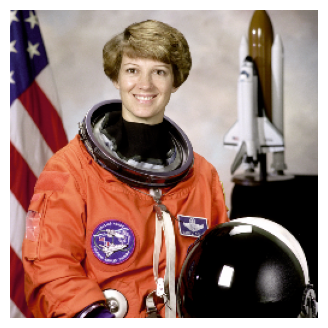

In [17]:
astronaut_img = astronaut()[::2,::2]/255.0
print(f"array shape: {astronaut_img.shape}")
print(f"array dtype: {astronaut_img.dtype}")

fig_astronaut, ax_astronaut = plt.subplots(figsize = (4, 4))
ax_astronaut.imshow(astronaut_img)
ax_astronaut.set_axis_off()

Now, we will divide up the image into multiple **superpixels**, which are groups of nearby pixels that convey some kind of visual information. For example, superpixels may represent entire objects in images.

Naturally, there are [many image segmentation algorithms available](https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_segmentations.html#sphx-glr-auto-examples-segmentation-plot-segmentations-py), but we have to pick one to begin with and `quickshift` is the default algorithm chosen by the authors of the original LIME paper and the Python package, so we will use that one too.

Just like many other community-developed open-source scientific packages, the scikit-image package also has some bugs. For example, the `quickshift` function returns an error when the input is in the 32 bit floating point format in the linux environment like Google Colab. Thus, we will use the `safe_quickshift` function defined below as a temporary workaround.

In [18]:
def safe_quickshift(original_image, **kwargs):
    return quickshift(np.float64(original_image), **kwargs)

By convention, the segmentation is represented by a 2D NumPy array of the same pixel size of the original array, in which each segment area is denoted by its own ID Number.

The `quickshift` function has the following three arguments. You can look up the [official documentation](https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.quickshift) for more instructions.

- `kernel_size`
  - Width of [Gaussian kernel](https://medium.com/@akumar5/computer-vision-gaussian-filter-from-scratch-b485837b6e09) used in smoothing the sample density  
  - Larger size means fewer segments
+ `max_dist`
  + Cut-off point for data distances
  + Larger distance means fewer segments
- `ratio`
  - This ratio considers pixel grouping based on color versus spatial organization
  - We recommend a ratio of 0.5

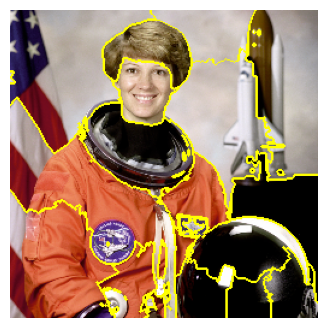

In [19]:
astronaut_seg = safe_quickshift(astronaut_img, kernel_size=8, max_dist=250, ratio=0.5)

fig_astronaut_seg, ax_astronaut_seg = plt.subplots(figsize = (4, 4))
ax_astronaut_seg.imshow(mark_boundaries(astronaut_img, astronaut_seg))
ax_astronaut_seg.set_axis_off()

In [20]:
print(f"segmentation array shape: {astronaut_seg.shape}")
print(f"segmentation array dtype: {astronaut_seg.dtype}")
print(f"segmentation array: \n", np.array2string(astronaut_seg, edgeitems=10), "\n")

n_segments = len(np.unique(astronaut_seg))
print(f"Number of segments: {n_segments}")
print(f"Segment IDs:\n {np.unique(astronaut_seg)}")

segmentation array shape: (256, 256)
segmentation array dtype: int64
segmentation array: 
 [[ 3  3  3  3  3  3  3  3  3  3 ...  2  2  2  2  2  2  2  2  2  2]
 [ 3  3  3  3  3  3  3  3  3  3 ...  2  2  2  2  2  2  2  2  2  2]
 [ 3  3  3  3  3  3  3  3  3  3 ...  2  2  2  2  2  2  2  2  2  2]
 [ 3  3  3  3  3  3  3  3  3  3 ...  2  2  2  2  2  2  2  2  2  2]
 [ 3  3  3  3  3  3  3  3  3  3 ...  2  2  2  2  2  2  2  2  2  2]
 [ 3  3  3  3  3  3  3  3  3  3 ...  2  2  2  2  2  2  2  2  2  2]
 [ 3  3  3  3  3  3  3  3  3  3 ...  2  2  2  2  2  2  2  2  2  2]
 [ 3  3  3  3  3  3  3  3  3  3 ...  2  2  2  2  2  2  2  2  2  2]
 [ 3  3  3  3  3  3  3  3  3  3 ...  2  2  2  2  2  2  2  2  2  2]
 [ 3  3  3  3  3  3  3  3  3  3 ...  2  2  2  2  2  2  2  2  2  2]
 ...
 [10 10 10 10 10 10 10 10 10 10 ... 15 15 15 15 15 15 15 15 15 15]
 [10 10 10 10 10 10 10 10 10 10 ... 15 15 15 15 15 15 15 15 15 15]
 [10 10 10 10 10 10 10 10 10 10 ... 15 15 15 15 15 15 15 15 15 15]
 [10 10 10 10 10 10 10 10 10 10 .

Since the segment ID is just an integer, we can easily create a Boolean mask to choose a specific segment area and do some operations on the original image array. For example, the ID number for the segment area around the space shuttle (not the fuel tank, but the shuttle itself) is 5.

mask shape: (256, 256)
mask dtype: bool


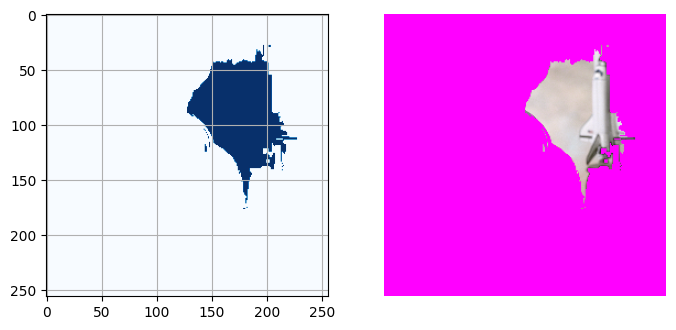

In [21]:
# creating a Boolean mask with element-wise NumPy operator
mask_for_specific_segment_area = (astronaut_seg == 5)
print(f"mask shape: {mask_for_specific_segment_area.shape}")
print(f"mask dtype: {mask_for_specific_segment_area.dtype}")

# Blank image filled with magenta
# Can you see how [1.0, 0.0, 1.0] is broadcast into the whole array?
shuttle_img = np.zeros(astronaut_img.shape, dtype=np.float64) + np.array([1.0, 0.0, 1.0])

# Copy the astonaut image only in the area selected by the Boolean mask
shuttle_img[mask_for_specific_segment_area] = astronaut_img[mask_for_specific_segment_area]

fig_seg_mask, ax_seg_mask = plt.subplots(1, 2, figsize=(8, 4))
ax_seg_mask[0].imshow(mask_for_specific_segment_area, cmap = "Blues")
ax_seg_mask[0].grid()
ax_seg_mask[1].imshow(shuttle_img)
ax_seg_mask[1].set_axis_off()

What we can do now is **fudge** each segment area, which is to **overwrite each pixel value with the mean values for each RGB color channel of all pixels in the segment**.

In [22]:
def fudge_image(original_image, segmentation):
    """fudge each segments of the image"""
    fudged_image = original_image.copy()
    for each_seg in np.unique(segmentation):
        each_seg_area_mask = (segmentation == each_seg)
        fudged_image[each_seg_area_mask] = np.mean(
            fudged_image[each_seg_area_mask], axis=0)

    return fudged_image

In [23]:
def display_original_and_fudged_image(original_image, fudged_image,
                                      segmentation, mode=None):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(original_image)
    ax[0].set_title("Orignal Image")
    ax[1].imshow(mark_boundaries(original_image, segmentation, mode=mode))
    ax[1].set_title("Segmented")
    ax[2].imshow(mark_boundaries(fudged_image, segmentation, mode=mode))
    ax[2].set_title("Segmented and fudged")
    ax[0].set_axis_off()
    ax[1].set_axis_off()
    ax[2].set_axis_off()

    return fig, ax

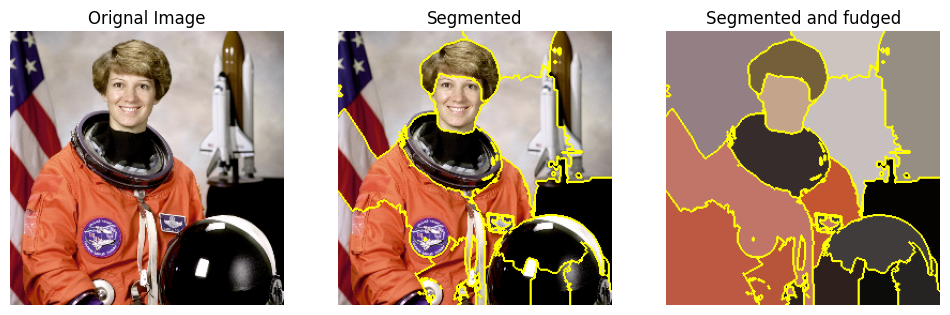

In [24]:
astronaut_fudged = fudge_image(astronaut_img, astronaut_seg)
fig_astronaut_fudgedd, ax_astronaut_fudgedd = \
    display_original_and_fudged_image(astronaut_img, astronaut_fudged, astronaut_seg)

Now it's time to perturb the image. Here, we also need a **segmentation vector**, which is a vector that tells us how exactly the orginal image has been perturbed. If the $i$-th element of the vector is 0, it means the $i$-th segment in the image is fudged, while 1 means that the segment has not been fudged.

For example, if the segmentation vector is $\vec{s} = [1, 1, 0, 0, 1]$, then only the third and fourth segments are fudged.

In [25]:
def perturb_image(original_image, fudged_image, segmentation,
                  seed=None):
    """return the perturbed image and the segmentation vector"""
    rng = np.random.default_rng(seed=seed)

    n_segments = len(np.unique(segmentation))
    # randomly choose image segments to perturb
    segmentation_vector_mask = rng.choice([True, False], size = n_segments)

    perturbed_image = fudged_image.copy()
    sampled_area_mask = segmentation_vector_mask[segmentation]
    perturbed_image[sampled_area_mask] = original_image[sampled_area_mask]

    return perturbed_image, segmentation_vector_mask.astype(np.int64)

In [26]:
def display_perturbations(original_image, fudged_image, segmentation,
                          initial_seed=None, show_vectors=True):
    """display twelve randomly perturbed images"""
    fig, ax = plt.subplots(3, 4, figsize=(12, 9))
    rng = np.random.default_rng(seed=initial_seed)

    for i, j in itertools.product(range(3), range(4)):
        seed = rng.integers(2**63)
        perturbed_image, seg_vec = perturb_image(original_image, fudged_image, segmentation, seed)

        ax[i, j].imshow(perturbed_image)
        ax[i, j].set_axis_off()

        if show_vectors:
            ax[i, j].text(int(0.05*perturbed_image.shape[0]), int(0.9*perturbed_image.shape[0]),
                          str(seg_vec), fontsize=8, bbox = dict(color="White", alpha=0.75))

    return fig, ax

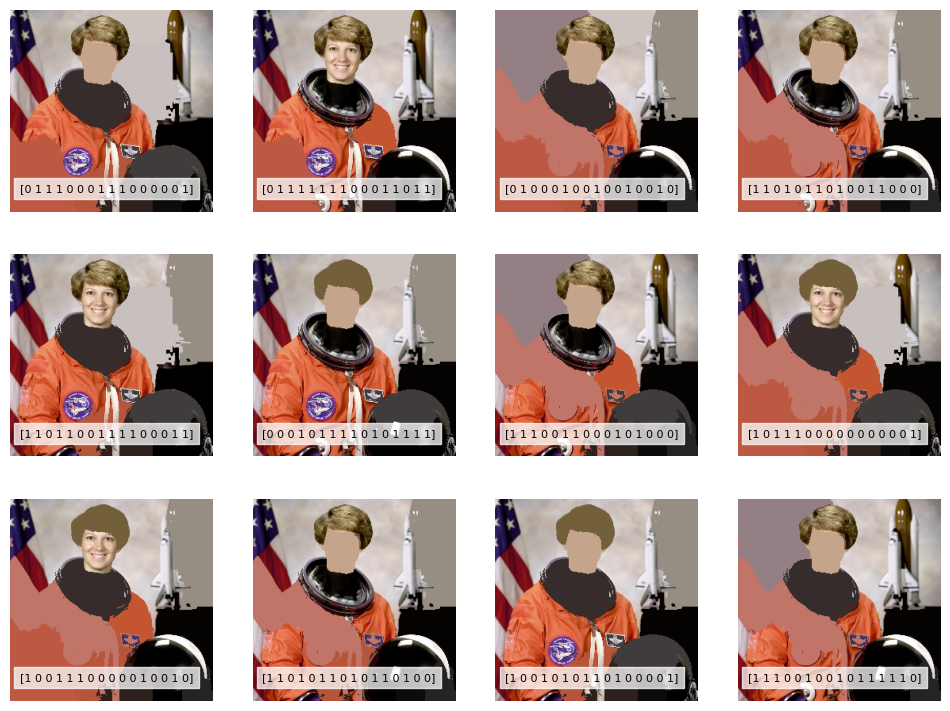

In [27]:
fig_astronaut_perturb, ax_astronaut_perturb = \
    display_perturbations(astronaut_img, astronaut_fudged, astronaut_seg)

PS. When you use the `make_boundries()` function, you might get a warning message like this when `mode="subpixel"`.

```
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
```

That's because `mark_boundaries()` uses `scipy.ndimage.zoom` internally to enlarge the original image of the size $(n,\, n)$ to obtain an image of the size $(2n-1, \, 2n-1)$, and [that zoom function uses cubic interpolation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.zoom.html), which can sometimes result in the pixel values below 0.0 or above 1.0.

### Create a CNN Model using the CIFAR10 Dataset

First let's load the CIFAR10 dataset. Here, we only need to load the test set, because TAs have already trained the model for you.

In [28]:
# No need to load the train set
image_test_full, label_test_full = unpickle_CIFAR(f"{data_path}/test")

# Keep cats and dogs only and throw away the other classes
cifar_class_list = ["cat", "dog"]
image_test_uint, label_test = get_subset(image_test_full, label_test_full,
                                         class_list=cifar_class_list,
                                         num=None)

# Shuffle and normalize
seed = 42
image_test_uint,  label_test  = shuffle_data(image_test_uint, label_test, seed)
image_test = np.float32(image_test_uint/255.0)

**We have prepared a model for you. All you need to do is just import the model via the h5 file.** If you want to build the model by yourself, you can copy and paste the code in this markdown cell.

<details> <summary> <b> Click here for the code </b> </summary>

```python
cnn_model = tf.keras.Sequential(
    layers = [
        # First Convolution Layer
        tf.keras.layers.Conv2D(filters=16, kernel_size=5, strides=(2, 2), padding="same", name="Conv1"),
        tf.keras.layers.BatchNormalization(axis=[1, 2], momentum=0, center=False, scale=False, name="Conv1-Norm"),
        tf.keras.layers.LeakyReLU(name="Conv1-LeakyReLU"),
        tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(1, 1), padding="same", name="Conv1-Pool"),
        # Second Convolution Layer
        tf.keras.layers.Conv2D(filters=20, kernel_size=5, strides=(2, 2), padding="same", name="Conv2"),
        tf.keras.layers.BatchNormalization(axis=[1, 2], momentum=0, center=False, scale=False, name="Conv2-Norm"),
        tf.keras.layers.LeakyReLU(name="Conv2-LeakyReLU"),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1), padding="same", name="Conv2-Pool"),
        # Third Convolution Layer
        tf.keras.layers.Conv2D(filters=20, kernel_size=3, strides=(1, 1), padding="same", name="Conv3"),
        tf.keras.layers.BatchNormalization(axis=[1, 2], momentum=0, center=False, scale=False, name="Conv3-Norm"),
        tf.keras.layers.LeakyReLU(name="Conv3-LeakyReLU"),
        # Three Dense Layers
        tf.keras.layers.Flatten(name="Flatten"),
        tf.keras.layers.Dense(160, activation="leaky_relu", name="Dense1"),
        tf.keras.layers.Dropout(rate=0.3, name="Dropout1"),
        tf.keras.layers.Dense(20, activation="leaky_relu", name="Dense2"),
        tf.keras.layers.Dropout(rate=0.3, name="Dropout2"),
        tf.keras.layers.Dense(2, activation="softmax", name="Dense3"),
    ],
    name = "cnn_model"
)
```
</details>

In [29]:
import json

# Open and read the JSON file
with open('/content/drive/MyDrive/Semester1/DeepLearning/model/cnn_model_export.json', 'r') as file:
    cnn_model_export = json.load(file)

cnn_model = tf.keras.models.model_from_json(cnn_model_export)
cnn_model.summary()

Model: "cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv1 (Conv2D)                       │ (None, 16, 16, 16)          │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1-Norm (BatchNormalization)      │ (None, 16, 16, 16)          │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1-LeakyReLU (LeakyReLU)          │ (None, 16, 16, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1-Pool (MaxPooling2D)            │ (None, 16, 16, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2 (Conv2D)                       │ (None, 8, 8, 20)            │           8,020 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2-Norm (BatchNormalization)      │ (None, 8, 8, 20)            │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2-LeakyReLU (LeakyReLU)          │ (None, 8, 8, 20)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2-Pool (MaxPooling2D)            │ (None, 8, 8, 20)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3 (Conv2D)                       │ (None, 8, 8, 20)            │           3,620 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3-Norm (BatchNormalization)      │ (None, 8, 8, 20)            │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3-LeakyReLU (LeakyReLU)          │ (None, 8, 8, 20)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten (Flatten)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense1 (Dense)                       │ (None, 160)                 │         204,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout1 (Dropout)                   │ (None, 160)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense2 (Dense)                       │ (None, 20)                  │           3,220 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout2 (Dropout)                   │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense3 (Dense)                       │ (None, 2)                   │              42 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 663,348 (2.53 MB)

 Trainable params: 221,078 (863.59 KB)

 Non-trainable params: 112 (448.00 B)

 Optimizer params: 442,158 (1.69 MB)

**You don't have to train the model at all, because you can just load the pretrained weights, prepared by the TAs,** although you could copy and paste the code in this cell if you really want to do it yourself.

<details> <summary> <b> Click here for the code </b> </summary>

```python
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
metrics = [tf.keras.metrics.CategoricalAccuracy()]

cnn_model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=metrics)

cnn_model.fit(x = image_train, y = oh_label_train,
              epochs = 30, batch_size = 64,
              validation_data = (image_test, oh_label_test), validation_freq = 5)

cnn_model_export = cnn_model.to_json()
with open(f"{model_path}/cnn_model_export.json", "w", encoding = "utf-8") as outfile:
    json.dump(cnn_model_export, outfile)
    
# you can change the name of the exported weights
cnn_model.save_weights(f"{model_path}/cnn_model_weights_TA")
```
</details>    

In [30]:
cifar_class_array = np.array(cifar_class_list)
predicted_labels = cifar_class_array[tf.argmax(cnn_model(image_test), axis=1)]

model_accuracy = np.sum(label_test == predicted_labels)/len(label_test)
print(f"accuracy BEFORE loading the weights = {model_accuracy:0.4f}")

accuracy BEFORE loading the weights = 0.4975


The trained model should have a higher accuracy than the untrained one.

In [31]:
# load the pretrained weights
cnn_model.load_weights(f"{model_path}/cnn_model_weights_TA.weights.h5")

cifar_class_array = np.array(cifar_class_list)
predicted_labels = cifar_class_array[tf.argmax(cnn_model(image_test), axis=1)]

model_accuracy = np.sum(label_test == predicted_labels)/len(label_test)
print(f"Accuracy AFTER loading the weights = {model_accuracy:0.4f}")

Accuracy AFTER loading the weights = 0.7455


### Throw LIME at Cats and Dogs

Please don't actually throw limes at your pets. I don't think they will like it. However, you can always apply the LIME algorithm to your image recognition model.  

Here are the specific steps to apply the LIME algorithm on a blackbox model for image recognition.

1. Generate many randomly perturbed segmented images.
   - Segment the original image into superpixels with the `safe_quickshift()` function.
   - Fudge the original image with the `fudge_image()` function.
   - Generate many perturbed images by calling the `perturb_image()` function many times.
   - Remember to collect the segmentation vectors.
2. Calculate the weights of each random perturbation based on the distance from the original image.
   + Use the `image_weight_kernel()` function.
3. Obtain the blackbox model's predicted probabilities for a particular label of your choice.
   - This is because you are curious about why the model has predicted that particular label.
   - Let's use the true label of the image in this lab.
   - You can also use the incorrect label of the image, if you are curious why the model has made the incorrect prediction.
4. Train the glassbox model
   + Use the segmentation vector as the feature variables and the blackbox probability as the target variable.
   + The default choice for the glassbox model is the lasso regression again
   + The size of the L1 penalty for the lasso regression has to be chosen carefully.
5. Interpret the glassbox model instead of the blackbox model
   - You can visualize the LIME interpretation by fudging and grayscale the unimportant segments of the image.
   - In the "glassbox_image", the important segments will remain in the original color, while the unimportant segments will be fudged and grayscaled.
   - Use the `rgb2gray_3ch()` function for grayscaling.
   - Use the `get_glassbox_iamge()` function for the lasso regression and to generate the glassbox image.

Now, let's walk through all these points! First, generate many randomly perturbed segmented CIFAR images.

cifar_label: cat
cifar_label_index: 0
Number of segments: 10


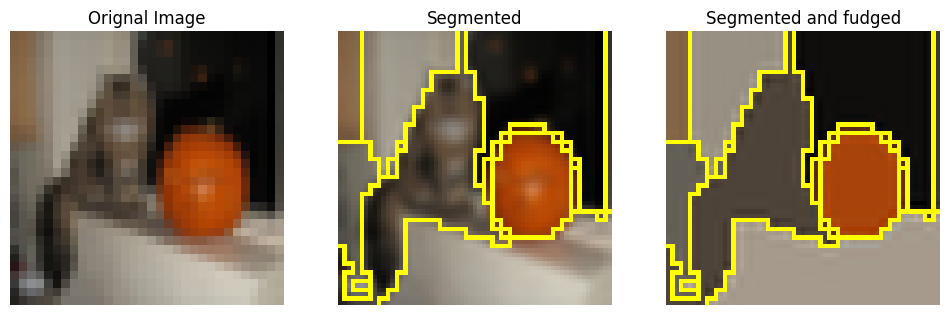

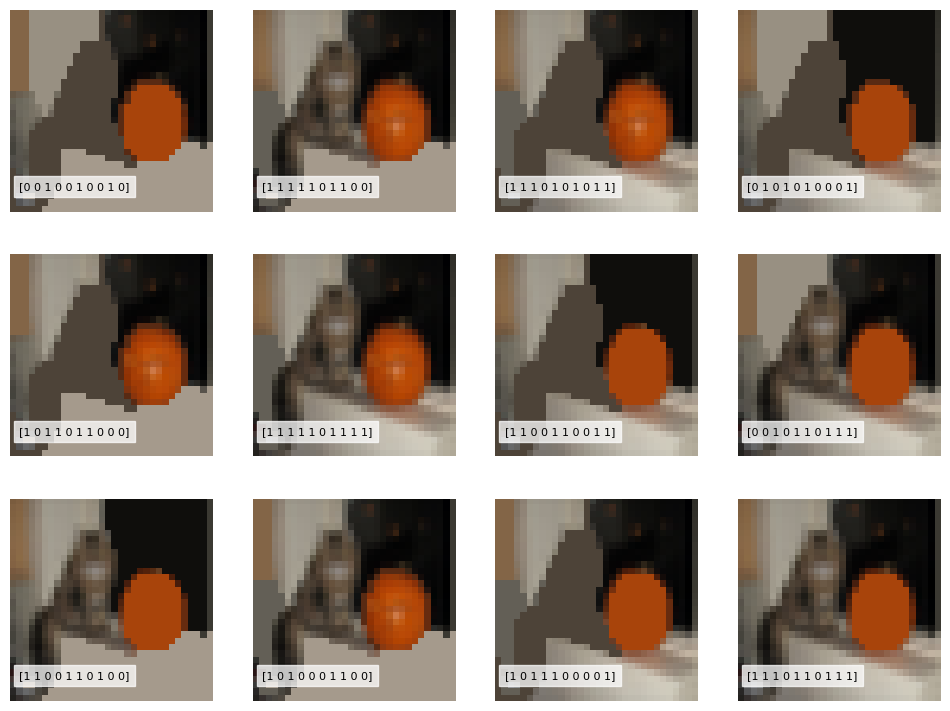

In [32]:
cifar_class_list = ["cat", "dog"]
cifar_class_dict = {"cat":0, "dog":1}
cifar_seg_params = dict(kernel_size=3, max_dist=7, ratio=0.5)

cifar_index = 219
cifar_image = image_test[cifar_index]
cifar_label = label_test[cifar_index]
cifar_label_index = cifar_class_dict[cifar_label]

print(f"cifar_label: {cifar_label}")
print(f"cifar_label_index: {cifar_label_index}")

cifar_seg = safe_quickshift(cifar_image, **cifar_seg_params)
cifar_fudged = fudge_image(cifar_image, cifar_seg)

print(f"Number of segments: {len(np.unique(cifar_seg))}")

fig_organge_cat, ax_orange_cat = \
    display_original_and_fudged_image(cifar_image, cifar_fudged, cifar_seg,
                                      mode="subpixel")
fig_test_perturb, ax_test_perturb = display_perturbations(cifar_image, cifar_fudged, cifar_seg)

Second, calculate the weights of each random perturbation based on the distance from the original image.

In [33]:
def image_weight_kernel(original_image, perturbed_image, kernel_size=5.0):
    # for a single RGB colored image only
    assert original_image.ndim == 3
    assert original_image.shape[2] == 3

    image_squared_distance = np.sum((original_image - perturbed_image)**2)
    lime_weights = np.exp(-image_squared_distance/(kernel_size**2))

    return lime_weights

Third, obtain the blackbox model's predicted probabilities for a particular label of your choice.

#### [Check-off 3] Lime Training Data for Image Models

Implement the `generate_lime_training_data()` function below.

- `original_label_index` is the index of the true label in the model's output.

For example, if the model's output is `[0.6, 0.4]` for the probability 0.6 for "cat" and 0.4 for "dog", and the true label is "cat", then `original_label_index` is 0 and `predicted_probability` is 0.6.

In [34]:
def generate_lime_training_data(original_image, fudged_image, segmentation,
                                original_label_index, cnn_model,
                                n_samples=400, initial_seed=None):
    """Returns the training data for the glassbox model that LIME uses to
      interpret image models.
    lime_X: Collection of segmentation vectors as the independent variable
      for the glassbox model np.array in the shape (n_samples, n_segments)
    lime_y: The CNN model's predicted probabilities on the true label from
      the perturbed images np.array in the shape (n_samples,)
    lime_w: The weights on each perturbed image from the function
      `image_weight_kernel()`
    """
    lime_X, lime_y, lime_w = [], [], []
    rng = np.random.default_rng(seed=initial_seed)

    for i in range(n_samples):
        seed = rng.integers(2**63)
        # TODO:

        # perturbed_image, segmentation_vector = do something with perturb_image()
        # perturbed_image, segmentation_vector = perturb_image(original_image, fudged_image, segmentation, initial_seed)
        perturbed_image, segmentation_vector = perturb_image(original_image, fudged_image, segmentation)
        # distance_weight = do something with image_weight_kernel()
        distance_weight = image_weight_kernel(original_image, perturbed_image)
        cnn_output = tf.squeeze(cnn_model(perturbed_image[np.newaxis, :]))
        # predicted_probability = do something with cnn_output and original_label_index
        predicted_probability = cnn_output[original_label_index]

        lime_X += [segmentation_vector]
        lime_y += [predicted_probability]
        lime_w += [distance_weight]

    lime_X, lime_y, lime_w = np.array(lime_X), np.array(lime_y), np.array(lime_w)

    return lime_X, lime_y, lime_w

Fourth, in get_glassbox_image we train the glassbox model. Lastly, we can interpret the glassbox model instead of the blackbox model.

In [35]:
def rgb2gray_3ch(original_image):
    """Desaturate the original image by repeating the gray channel three times"""
    gray_image_1ch = rgb2gray(original_image)[:, :, np.newaxis]
    gray_image_3ch = np.repeat(gray_image_1ch, repeats=3, axis=2)

    return gray_image_3ch

In [36]:
def get_glassbox_image(original_image, fudged_image, segmentation, lime_X, lime_y, lime_w):
    """returns the glassbox image
    in which the important part is in the original color
    and the unimportant part is fudged and grayscaled"""

    glassbox_lasso = Lasso(alpha=0.001).fit(lime_X, lime_y, sample_weight=lime_w) # this is step 4 where we train the glassbox model
    important_seg_mask = (glassbox_lasso.coef_ > 0)
    important_area_mask = important_seg_mask[segmentation]

    glassbox_image = rgb2gray_3ch(fudged_image)
    glassbox_image[important_area_mask] = original_image[important_area_mask]

    return glassbox_image

#### [Check-off 4] LIME on Image Models

Now it's the time to put everything together and assemble the full LIME algorithm into the single function `lime_image()` below.
- `segmentation`: First, you have to segment the original image with the function `safe_quickshift`. Make sure you input the correct default keyward arguments defined in the Python dictionary `seg_params`.
- `fudged_image`: Second, you have to fudge the image with the function `fudge_image()`.
- `lime_X`, `lime_y`, and `lime_w`: Then, you need the data to train the glassbox model. Use the function `generate_lime_training_data()` and input the correct default keyward arguments `n_samples` and `initial_seed`.
- `glassbox_image`: Finally, create the glassbox image with the function `get_glassbox_image()`.

In [37]:
def lime_image(original_image, original_label, label_dict, cnn_model,
               seg_params=cifar_seg_params, n_samples=400, initial_seed=None):
    """returns the glassbox image, fudged image, and segmentation"""
    original_label_index = label_dict[original_label]

    # TODO:

    # segmentation = do something with safe_quickshift()
    segmentation = safe_quickshift(original_image, **seg_params)
    # fudged_image = do something with fudge_image()
    fudged_image = fudge_image(original_image, segmentation)
    # lime_X, lime_y, lime_w = do something with generate_lime_training_data()
    lime_X, lime_y, lime_w = generate_lime_training_data(original_image, fudged_image, segmentation,
                                original_label_index, cnn_model,
                                n_samples, initial_seed)

    # glassbox_image = do something with get_glassbox_image()
    glassbox_image = get_glassbox_image(original_image, fudged_image, segmentation, lime_X, lime_y, lime_w)

    return glassbox_image, fudged_image, segmentation

In [38]:
def display_lime(original_image, fudged_image, segmentation,
                 glassbox_image,
                 mode=None):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(original_image)
    ax[0].set_title("Orignal Image")
    ax[1].imshow(mark_boundaries(fudged_image, segmentation, mode=mode))
    ax[1].set_title("Segmented and fudged")
    ax[2].imshow(glassbox_image)
    ax[2].set_title("LIME")
    ax[0].set_axis_off()
    ax[1].set_axis_off()
    ax[2].set_axis_off()

    return fig, ax

After everything's done, you can finally inspect how the CNN model makes predictions on the CIFAR10 testing images.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00



CPU times: user 2min 34s, sys: 1.45 s, total: 2min 36s
Wall time: 2min 46s


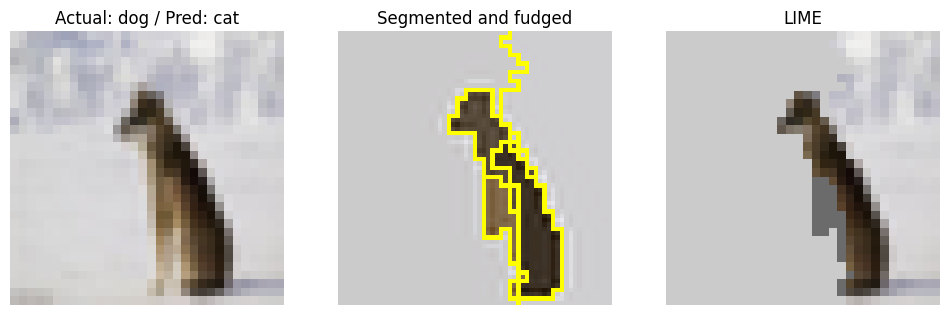

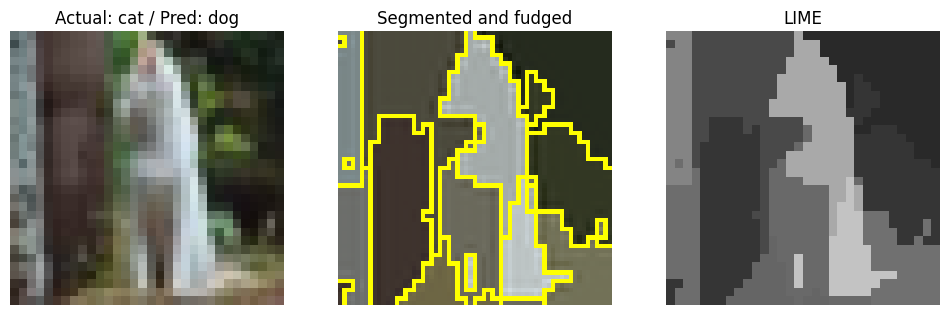

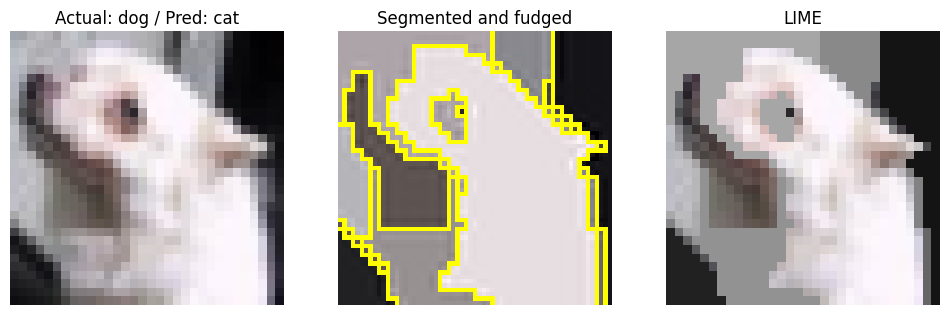

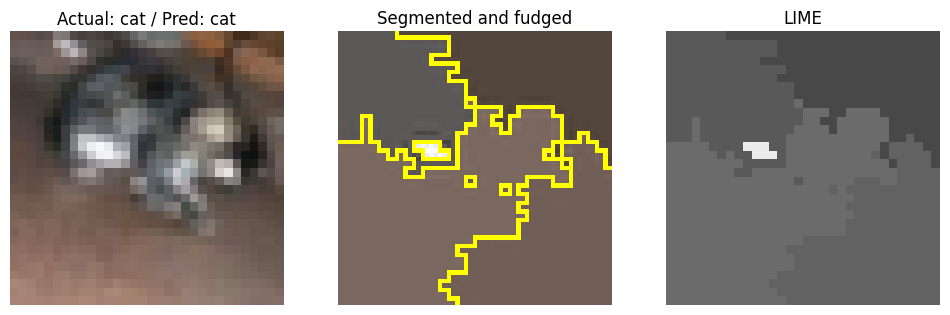

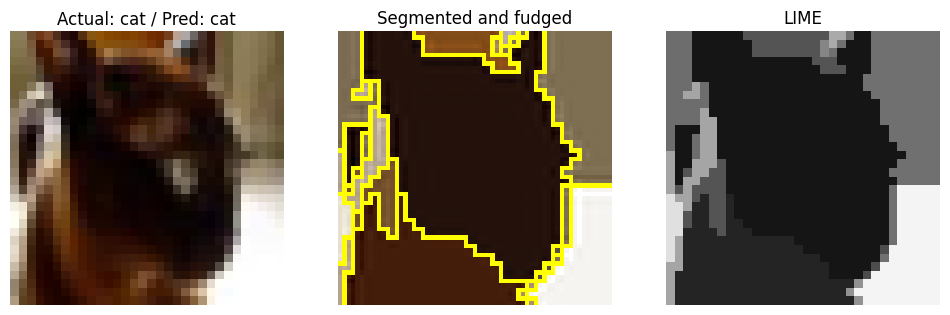

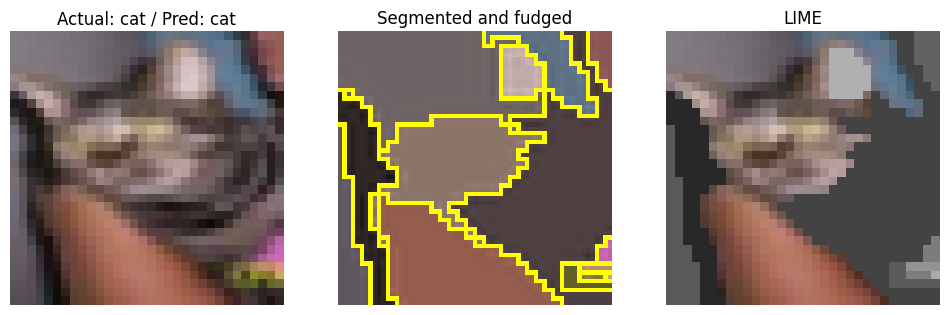

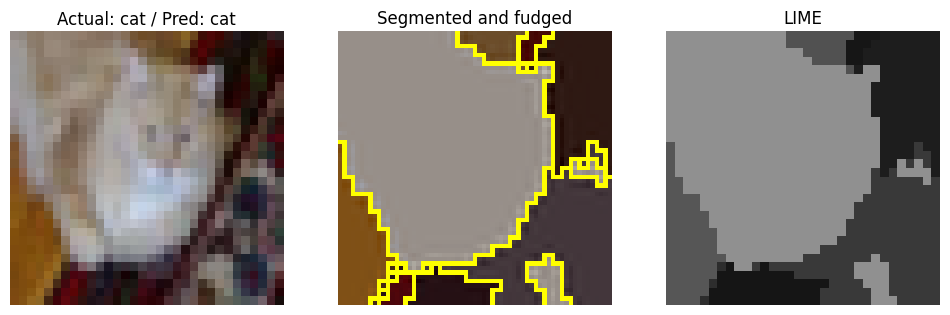

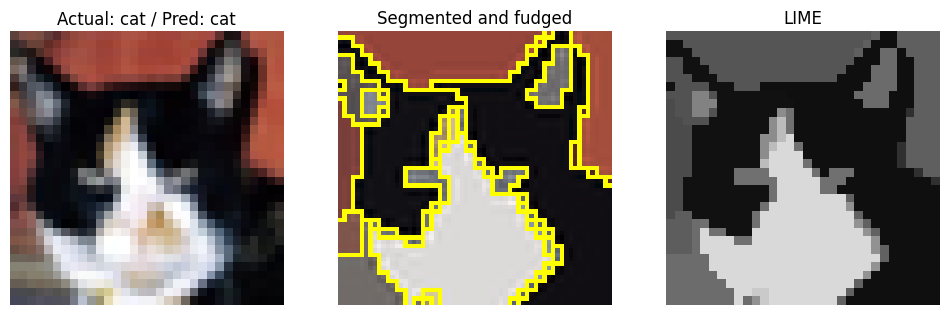

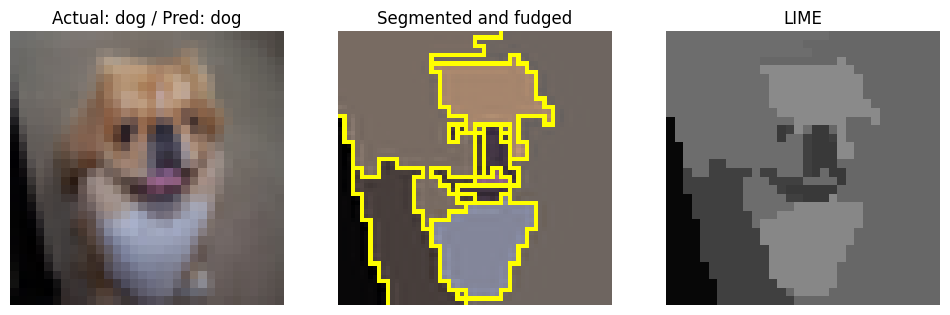

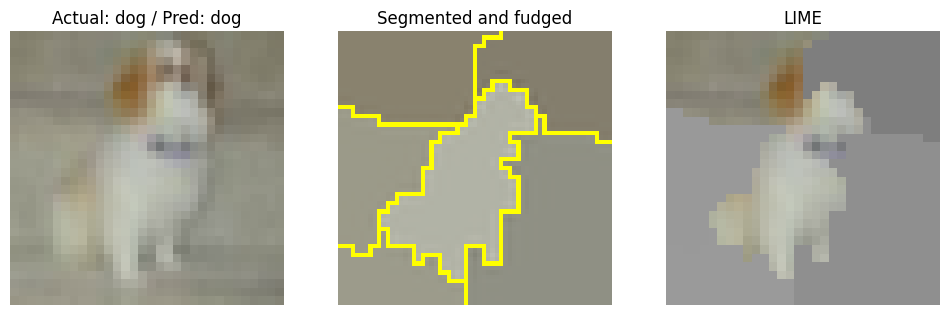

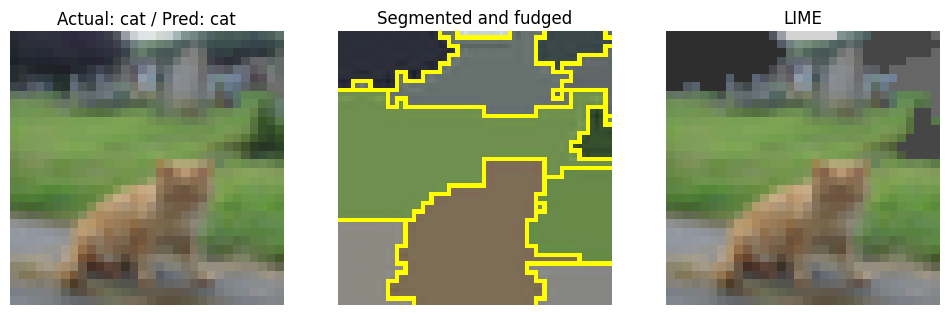

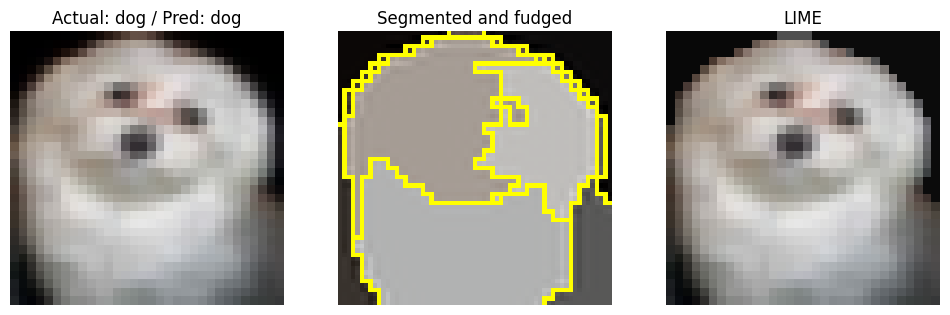

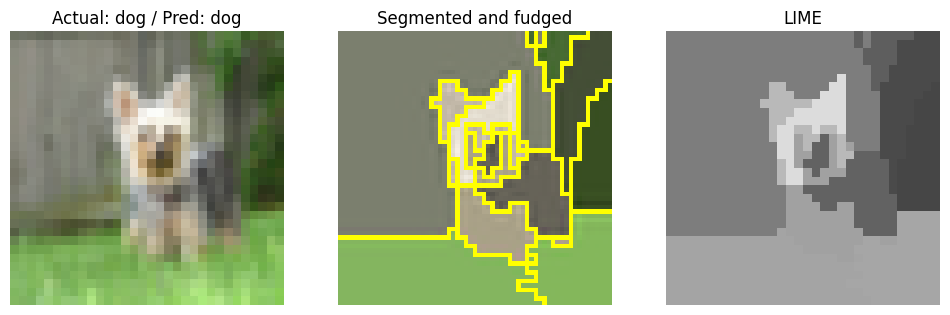

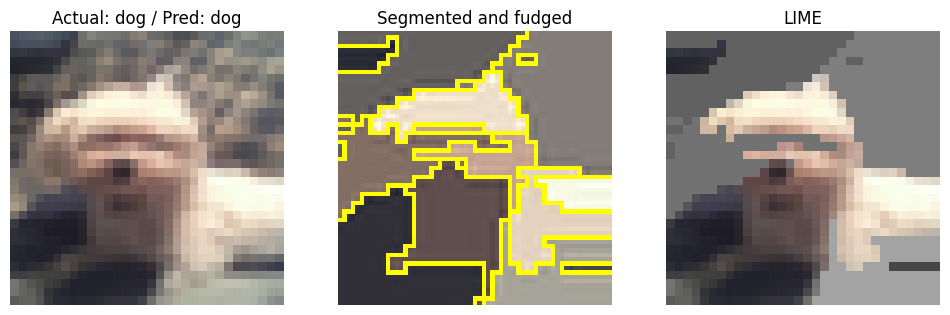

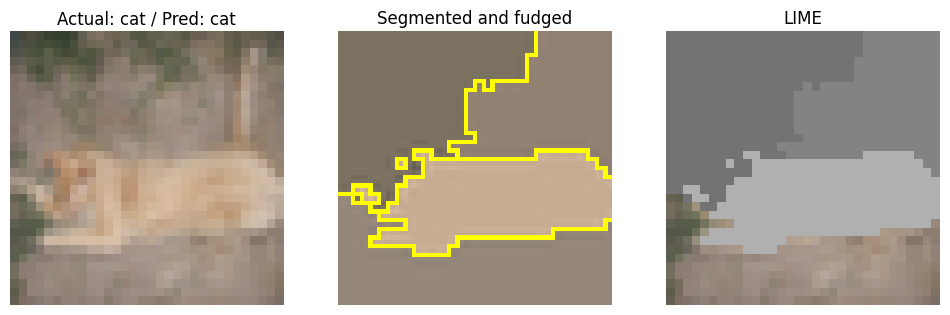

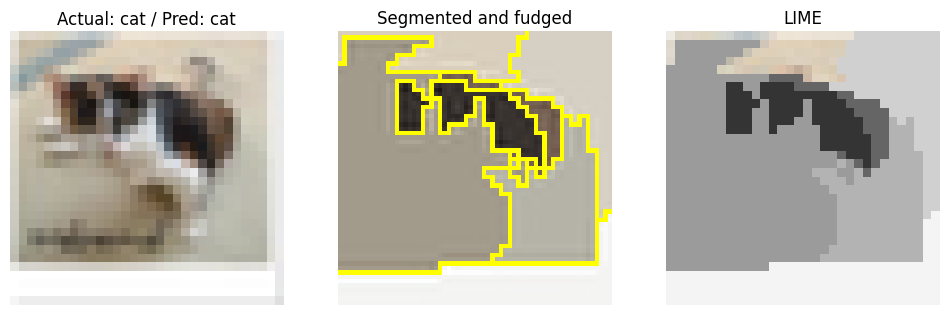

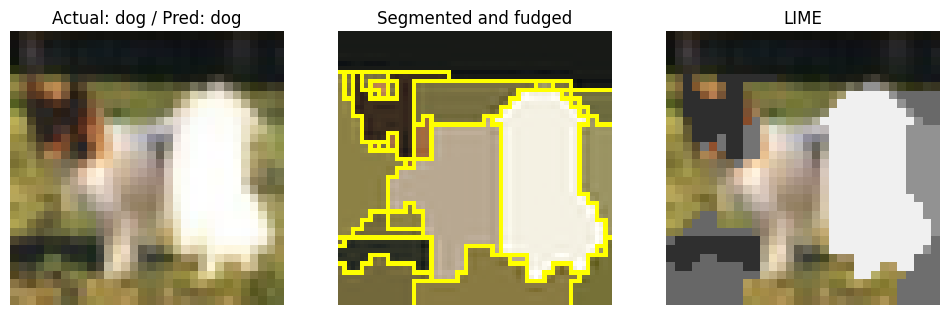

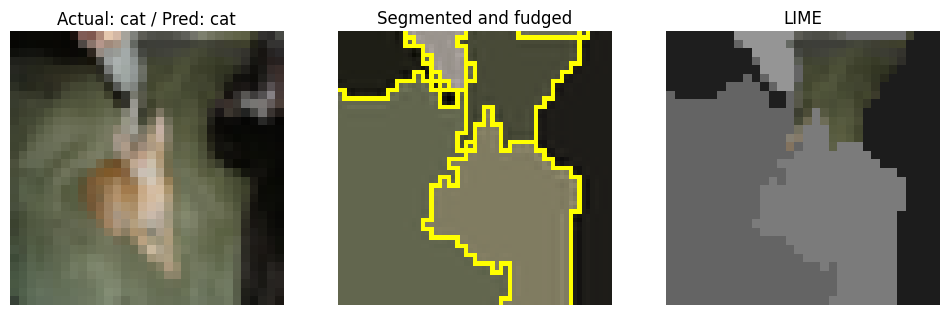

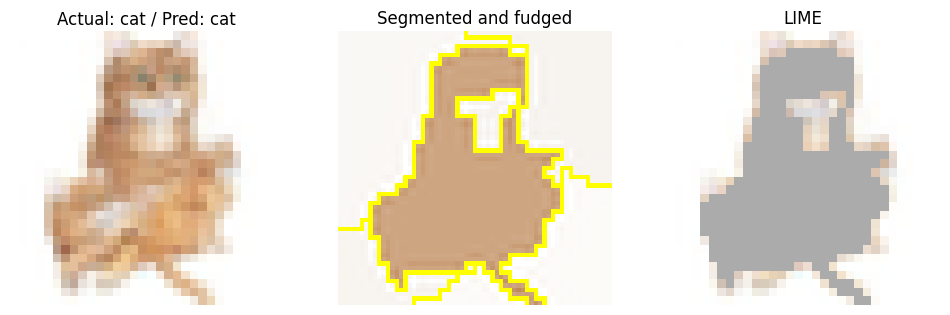

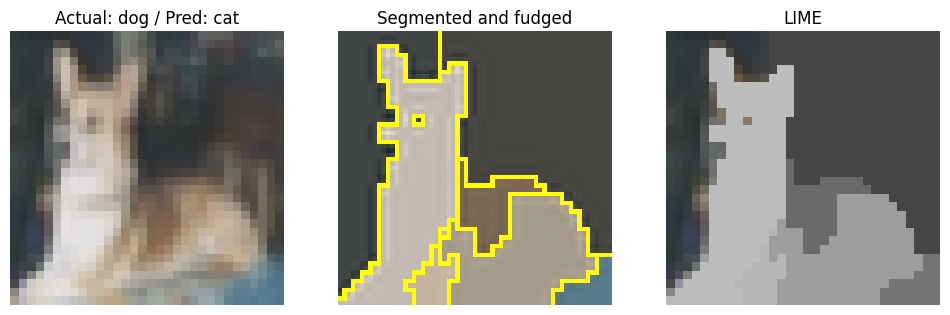

In [39]:
%%time
# [25, 32, 43, 56, 219]
for each_index in range(0, 20):
    cifar_image = image_test[each_index]
    cifar_label = label_test[each_index]
    cifar_glass, cifar_fudged, cifar_seg = lime_image(cifar_image, cifar_label,
                                                   cifar_class_dict, cnn_model)

    cifar_predicted = cifar_class_list[tf.argmax(tf.squeeze(
        cnn_model(cifar_image[np.newaxis, :])))]

    fig_test, ax_test = display_lime(cifar_image, cifar_fudged, cifar_seg,
                                     cifar_glass,
                                     mode="subpixel")
    ax_test[0].set_title(f"Actual: {cifar_label} / Pred: {cifar_predicted}")

#A brief survey of other techniques

[Write-Up] Select one of the following papers, and along with your completed notebook, submit a brief write-up of the main ideas from the paper and things that you found interesting about the approach.

SHAP: https://arxiv.org/pdf/1705.07874

Grad-CAM: https://arxiv.org/abs/1610.02391

## Acknowledgements & Sources

This lab is written by TA Yeunun Choo and edited by HTAs Vadim Kudlay and Nitya Thakkar

- [LIME paper](https://arxiv.org/abs/1602.04938?context=cs)
- [Python LIME package](https://github.com/marcotcr/lime)